# Group Details

## Group Name: 12

### Student 1: Denise La Gordt Dillie

### Student 2: Andreea Maican

### Student 3: Sambhav Jain

# Loading Data and Preliminaries

In [14]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import os
import math
import random
import time
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm

In [15]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")

In [16]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_array('/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(initial_state)
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
[[ 4.54673709 -5.27118739  5.07863417 -1.09690628 -3.66929964]
 [ 3.57509525  4.3270607  -0.08095022 -0.57868726 -2.95971243]
 [ 2.67733735 -5.15972108  5.35238208  2.42652043  1.45870728]
 [ 2.27455417 -6.79584511  2.29632123  0.30418238 -0.4065998 ]
 [ 2.38359341 -2.75861066  1.77940931 -0.07643627 -0.35954359]
 [ 4.28596268  0.34981219  4.8286224   1.35630962 -2.55760522]
 [ 3.03118516 -0.50562258 15.04631712 -0.94772523 14.98127867]
 [ 4.13530017  1.81342682  3.84375499 -0.6989711  -2.25092411]]
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [17]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time. 
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_array('/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array('/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


In [18]:
test_initial_state

array([[ 4.31455329, -4.99311363, -5.10150489,  2.2491171 , -1.82520359],
       [ 2.58525749, -4.92574075, -4.7534334 , -4.81897728, -3.07212095],
       [ 2.40449047,  2.23254187, -6.04595524, -0.67381217, -0.58798851],
       [ 2.28318603,  5.6605113 , -3.76376281, -0.41268251, -1.19812499],
       [ 4.09793595, -4.73678906, -3.94704856,  1.13634781,  4.98383634],
       [ 4.5579536 , -0.08848969,  5.42483477,  1.460317  , -0.21585929],
       [ 3.42356878, -4.91282501, -4.6779343 ,  0.94123905,  2.66425652],
       [ 3.59288181, -4.48225046, -4.548729  , -2.56573061, -2.39203918]])

# Data Handling and Preprocessing

In [19]:
def create_graph_data(initial_state, terminal_state):
    '''Takes a datapoint from task 1 data and returns a Data object ready to be used with
    Pytorch Geometric. Each node is an object and will store initial position and speed, each edge stores
    the distance between two objects and also their masses.'''
    initial_state = np.array(initial_state)
    terminal_state = np.array(terminal_state)

    n_bodies = initial_state.shape[0]
    num_features = initial_state.shape[1]

    # Create node features tensor
    node_features = torch.tensor(initial_state, dtype=torch.float)
    node_features = node_features.view(-1, num_features)  # Reshape to (num_nodes, num_features)

    # Create edge index tensor
    edge_index = torch.tensor([[i, j] for i in range(n_bodies) for j in range(n_bodies) if (i != j and i<j)], dtype=torch.long)
    edge_index = edge_index.t().contiguous()  # Reshape to (2, num_edges)

    # Create edge features tensor
    num_edges = edge_index.size(1)
    edge_features = torch.empty(num_edges, 1, dtype=torch.float)
    # Populate edge features with force
    for k, (i, j) in enumerate(edge_index.t()):
        dx = node_features[i, 1] - node_features[j, 1]
        dy = node_features[i, 2] - node_features[j, 2]
        distance = torch.sqrt(dx**2 + dy**2)
        force = ((node_features[i,0]*node_features[j,0])/(distance**2 + 1e-8))
        edge_features[k] = force

    # Create target tensor
    target = torch.tensor(terminal_state, dtype=torch.float).view(-1, 2)  # Reshape to (num_nodes, num_features + 1)

    # Create PyG Data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=target)

    return data

# Example usage
initial_state = [[1.0, 0.5, 0.3, 0.2, 0.1], [2.0, 0.1, 0.4, 0.3, 0.2], [0.5, 0.7, 0.8, 0.9, 1.0]]
terminal_state = [[0.3, 0.2], [0.4, 0.6], [0.8, 0.9]]

graph_data = create_graph_data(initial_state, terminal_state)
print(graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.y)

tensor([[1.0000, 0.5000, 0.3000, 0.2000, 0.1000],
        [2.0000, 0.1000, 0.4000, 0.3000, 0.2000],
        [0.5000, 0.7000, 0.8000, 0.9000, 1.0000]]) tensor([[0, 0, 1],
        [1, 2, 2]]) tensor([[11.7647],
        [ 1.7241],
        [ 1.9231]]) tensor([[0.3000, 0.2000],
        [0.4000, 0.6000],
        [0.8000, 0.9000]])


In [20]:
def create_dataloader(data_folder, task, shuffle, batch_size, train_ratio=0.8):
    data_list = []  # List to store the Data objects

    # Loop over all files in the folder
    for filename in os.listdir(data_folder):
        file_path = os.path.join(data_folder, filename)

        # Read the data from the file (modify this part based on your file format)
        states = load_array(file_path, task=task)
        initial_state, terminal_state = states

        # Create the Data object using create_graph_data function
        data = create_graph_data(initial_state, terminal_state)

        # Append the Data object to the list
        data_list.append(data)

    # Shuffle the data if specified
    if shuffle:
        random.shuffle(data_list)

    # Calculate the number of samples
    num_samples = len(data_list)

    if "train" in data_folder:
        # Calculate the number of samples for train and validation
        num_train = int(train_ratio * num_samples)
        num_val = num_samples - num_train

        # Split the data into train and validation sets
        train_data = data_list[:num_train]
        val_data = data_list[num_train:]

        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")
        print(f"Number of training samples: {num_train}")
        print(f"Number of validation samples: {num_val}")

        # Create data loaders for train and validation sets
        dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        return dataloader_train, dataloader_val, data_list
    else:
        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")

        # Create a data loader for the data
        dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=shuffle)

        return dataloader, data_list

# Specify the paths to your train and test data folders
data_folder_train = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/train'
data_folder_test = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/test'

# Define the batch size
batch_size = 50

# Create data loaders for train and validation sets (only if the folder contains "train")
dataloader_train, dataloader_val, data_list = create_dataloader(data_folder_train, task='task 1', shuffle=True, batch_size=batch_size)

# Create a separate data loader for the test set
dataloader_test, data_list_test = create_dataloader(data_folder_test, task='task 1', shuffle=False, batch_size=batch_size)

Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/train: 900
Number of training samples: 720
Number of validation samples: 180
Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/test: 100


# Task 1

# Model Implementation

In [21]:
from torch_geometric.nn import SAGEConv

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()

        self.conv1 = SAGEConv(5, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, 256)
        self.conv4 = SAGEConv(256, 512)
        self.conv5 = SAGEConv(512, 256)
        self.conv6 = SAGEConv(256, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = self.conv6(x, edge_index)

        return x

# Model Training

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


In [23]:
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = torch.nn.MSELoss()

def train(loader):
    model.train()
    total_loss = 0
    total_r2_score = 0
    total_mae = 0
    total_samples = 0

    for data in loader:
        data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predictions = output.detach().cpu().numpy()
        true_labels = data.y.detach().cpu().numpy()
        batch_size = true_labels.shape[0]
        total_samples += batch_size

         # R2 Score
        total_r2_score += r2_score(true_labels, predictions) * batch_size

        # MAE
        mae = mean_absolute_error(true_labels, predictions)
        total_mae += mae * batch_size

    avg_loss = total_loss / len(loader)
    avg_r2_score = total_r2_score / total_samples
    avg_mae = total_mae / total_samples

    return avg_loss, avg_r2_score, avg_mae

def evaluate(loader):
    model.eval()
    total_loss = 0
    total_r2_score = 0
    total_mae = 0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            data.to(device)
            output = model(data)
            loss = loss_func(output, data.y)
            total_loss += loss.item()

            predictions = output.detach().cpu().numpy()
            true_labels = data.y.detach().cpu().numpy()
            batch_size = true_labels.shape[0]
            total_samples += batch_size

            # R2 Score
            total_r2_score += r2_score(true_labels, predictions) * batch_size

            # MAE
            mae = mean_absolute_error(true_labels, predictions)
            total_mae += mae * batch_size

    avg_loss = total_loss / len(loader)
    avg_r2_score = total_r2_score / total_samples
    avg_mae = total_mae / total_samples

    return avg_loss, avg_r2_score, avg_mae

In [24]:
epochs = 50
start = time.time()

train_losses, train_r2_scores, train_maes = [], [], []
val_losses, val_r2_scores, val_maes = [], [], []
test_losses, test_r2_scores, test_maes = [], [], []

for epoch in tqdm(range(1, epochs + 1)):

    train_loss, train_r2_score, train_mae = train(dataloader_train)
    val_loss, val_r2_score, val_mae = evaluate(dataloader_val)
    test_loss, test_r2_score, test_mae = evaluate(dataloader_test)

    toc = time.time()
    print(f'EPOCH: {epoch:03d}, TRAIN LOSS: {train_loss:.4f}, VAL LOSS: {val_loss:.4f}, TEST LOSS: {test_loss:.4f}. TRAINING TIME SO FAR: {toc - start:.1f} s\n'
          f'TRAIN R2: {train_r2_score:.4f}, VAL R2: {val_r2_score:.4f}, TEST R2: {test_r2_score:.4f}\n'
          f'TRAIN MAE: {train_mae:.4f}, VAL MAE: {val_mae:.4f}, TEST MAE: {test_mae:.4f}\n')

    # Store metrics
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)
    train_maes.append(train_mae)

    val_losses.append(val_loss)
    val_r2_scores.append(val_r2_score)
    val_maes.append(val_mae)

    test_losses.append(test_loss)
    test_r2_scores.append(test_r2_score)
    test_maes.append(test_mae)

  2%|▏         | 1/50 [00:00<00:08,  5.83it/s]

EPOCH: 001, TRAIN LOSS: 16.9683, VAL LOSS: 9.1231, TEST LOSS: 7.4549. TRAINING TIME SO FAR: 0.2 s
TRAIN R2: 0.2524, VAL R2: 0.5784, TEST R2: 0.6396
TRAIN MAE: 3.2509, VAL MAE: 2.3708, TEST MAE: 2.1433



  4%|▍         | 2/50 [00:00<00:08,  5.80it/s]

EPOCH: 002, TRAIN LOSS: 8.6930, VAL LOSS: 7.3519, TEST LOSS: 5.6389. TRAINING TIME SO FAR: 0.3 s
TRAIN R2: 0.6270, VAL R2: 0.6618, TEST R2: 0.7273
TRAIN MAE: 2.1937, VAL MAE: 2.0874, TEST MAE: 1.8667



  6%|▌         | 3/50 [00:00<00:08,  5.81it/s]

EPOCH: 003, TRAIN LOSS: 7.4095, VAL LOSS: 6.7953, TEST LOSS: 5.1847. TRAINING TIME SO FAR: 0.5 s
TRAIN R2: 0.6858, VAL R2: 0.6872, TEST R2: 0.7500
TRAIN MAE: 1.9962, VAL MAE: 1.9839, TEST MAE: 1.7658



  8%|▊         | 4/50 [00:00<00:07,  5.79it/s]

EPOCH: 004, TRAIN LOSS: 6.7651, VAL LOSS: 6.6621, TEST LOSS: 5.1856. TRAINING TIME SO FAR: 0.7 s
TRAIN R2: 0.7098, VAL R2: 0.6929, TEST R2: 0.7498
TRAIN MAE: 1.9078, VAL MAE: 1.9651, TEST MAE: 1.7491



 10%|█         | 5/50 [00:00<00:07,  5.77it/s]

EPOCH: 005, TRAIN LOSS: 6.7229, VAL LOSS: 6.6220, TEST LOSS: 4.9880. TRAINING TIME SO FAR: 0.9 s
TRAIN R2: 0.7115, VAL R2: 0.6948, TEST R2: 0.7592
TRAIN MAE: 1.9009, VAL MAE: 1.9366, TEST MAE: 1.7276



 12%|█▏        | 6/50 [00:01<00:07,  5.77it/s]

EPOCH: 006, TRAIN LOSS: 6.4204, VAL LOSS: 6.6844, TEST LOSS: 5.2610. TRAINING TIME SO FAR: 1.0 s
TRAIN R2: 0.7247, VAL R2: 0.6899, TEST R2: 0.7462
TRAIN MAE: 1.8619, VAL MAE: 1.9591, TEST MAE: 1.7607



 14%|█▍        | 7/50 [00:01<00:07,  5.79it/s]

EPOCH: 007, TRAIN LOSS: 6.2848, VAL LOSS: 6.7708, TEST LOSS: 5.2512. TRAINING TIME SO FAR: 1.2 s
TRAIN R2: 0.7268, VAL R2: 0.6882, TEST R2: 0.7467
TRAIN MAE: 1.8632, VAL MAE: 1.9851, TEST MAE: 1.7679



 16%|█▌        | 8/50 [00:01<00:07,  5.80it/s]

EPOCH: 008, TRAIN LOSS: 6.2215, VAL LOSS: 6.5749, TEST LOSS: 5.0896. TRAINING TIME SO FAR: 1.4 s
TRAIN R2: 0.7337, VAL R2: 0.6968, TEST R2: 0.7545
TRAIN MAE: 1.8407, VAL MAE: 1.9342, TEST MAE: 1.7308



 18%|█▊        | 9/50 [00:01<00:07,  5.81it/s]

EPOCH: 009, TRAIN LOSS: 5.8700, VAL LOSS: 6.8216, TEST LOSS: 4.9227. TRAINING TIME SO FAR: 1.6 s
TRAIN R2: 0.7401, VAL R2: 0.6859, TEST R2: 0.7620
TRAIN MAE: 1.8148, VAL MAE: 1.9694, TEST MAE: 1.7082



 20%|██        | 10/50 [00:01<00:06,  5.81it/s]

EPOCH: 010, TRAIN LOSS: 5.7485, VAL LOSS: 6.7103, TEST LOSS: 5.1922. TRAINING TIME SO FAR: 1.7 s
TRAIN R2: 0.7499, VAL R2: 0.6908, TEST R2: 0.7494
TRAIN MAE: 1.7912, VAL MAE: 1.9344, TEST MAE: 1.7352



 22%|██▏       | 11/50 [00:01<00:06,  5.75it/s]

EPOCH: 011, TRAIN LOSS: 5.5911, VAL LOSS: 6.7333, TEST LOSS: 5.0375. TRAINING TIME SO FAR: 1.9 s
TRAIN R2: 0.7539, VAL R2: 0.6882, TEST R2: 0.7568
TRAIN MAE: 1.7783, VAL MAE: 1.9420, TEST MAE: 1.6908



 24%|██▍       | 12/50 [00:02<00:06,  5.50it/s]

EPOCH: 012, TRAIN LOSS: 5.3883, VAL LOSS: 6.5702, TEST LOSS: 5.0476. TRAINING TIME SO FAR: 2.1 s
TRAIN R2: 0.7625, VAL R2: 0.6978, TEST R2: 0.7562
TRAIN MAE: 1.7522, VAL MAE: 1.9222, TEST MAE: 1.7277



 26%|██▌       | 13/50 [00:02<00:06,  5.60it/s]

EPOCH: 013, TRAIN LOSS: 5.3551, VAL LOSS: 6.7208, TEST LOSS: 5.3529. TRAINING TIME SO FAR: 2.3 s
TRAIN R2: 0.7662, VAL R2: 0.6890, TEST R2: 0.7419
TRAIN MAE: 1.7300, VAL MAE: 1.9486, TEST MAE: 1.7443



 28%|██▊       | 14/50 [00:02<00:06,  5.65it/s]

EPOCH: 014, TRAIN LOSS: 6.0886, VAL LOSS: 7.0049, TEST LOSS: 5.1469. TRAINING TIME SO FAR: 2.4 s
TRAIN R2: 0.7395, VAL R2: 0.6754, TEST R2: 0.7514
TRAIN MAE: 1.8116, VAL MAE: 2.0020, TEST MAE: 1.7224



 30%|███       | 15/50 [00:02<00:06,  5.70it/s]

EPOCH: 015, TRAIN LOSS: 5.9662, VAL LOSS: 6.5986, TEST LOSS: 4.8575. TRAINING TIME SO FAR: 2.6 s
TRAIN R2: 0.7492, VAL R2: 0.6952, TEST R2: 0.7657
TRAIN MAE: 1.7465, VAL MAE: 1.9220, TEST MAE: 1.6910



 32%|███▏      | 16/50 [00:02<00:05,  5.71it/s]

EPOCH: 016, TRAIN LOSS: 5.5942, VAL LOSS: 6.7154, TEST LOSS: 4.9931. TRAINING TIME SO FAR: 2.8 s
TRAIN R2: 0.7681, VAL R2: 0.6902, TEST R2: 0.7593
TRAIN MAE: 1.6889, VAL MAE: 1.9399, TEST MAE: 1.7146



 34%|███▍      | 17/50 [00:02<00:05,  5.71it/s]

EPOCH: 017, TRAIN LOSS: 5.2785, VAL LOSS: 6.6277, TEST LOSS: 4.9088. TRAINING TIME SO FAR: 3.0 s
TRAIN R2: 0.7746, VAL R2: 0.6943, TEST R2: 0.7635
TRAIN MAE: 1.6811, VAL MAE: 1.9149, TEST MAE: 1.6653



 36%|███▌      | 18/50 [00:03<00:05,  5.74it/s]

EPOCH: 018, TRAIN LOSS: 4.7907, VAL LOSS: 6.5672, TEST LOSS: 4.9422. TRAINING TIME SO FAR: 3.1 s
TRAIN R2: 0.7899, VAL R2: 0.6974, TEST R2: 0.7618
TRAIN MAE: 1.6298, VAL MAE: 1.9186, TEST MAE: 1.7017



 38%|███▊      | 19/50 [00:03<00:05,  5.74it/s]

EPOCH: 019, TRAIN LOSS: 4.6717, VAL LOSS: 6.6165, TEST LOSS: 4.8658. TRAINING TIME SO FAR: 3.3 s
TRAIN R2: 0.7955, VAL R2: 0.6935, TEST R2: 0.7654
TRAIN MAE: 1.6174, VAL MAE: 1.9082, TEST MAE: 1.6655



 40%|████      | 20/50 [00:03<00:05,  5.76it/s]

EPOCH: 020, TRAIN LOSS: 4.3761, VAL LOSS: 6.6648, TEST LOSS: 4.9388. TRAINING TIME SO FAR: 3.5 s
TRAIN R2: 0.8075, VAL R2: 0.6918, TEST R2: 0.7617
TRAIN MAE: 1.5713, VAL MAE: 1.9303, TEST MAE: 1.6813



 42%|████▏     | 21/50 [00:03<00:05,  5.76it/s]

EPOCH: 021, TRAIN LOSS: 4.2217, VAL LOSS: 6.6721, TEST LOSS: 4.8742. TRAINING TIME SO FAR: 3.7 s
TRAIN R2: 0.8135, VAL R2: 0.6929, TEST R2: 0.7648
TRAIN MAE: 1.5372, VAL MAE: 1.9169, TEST MAE: 1.6883



 44%|████▍     | 22/50 [00:03<00:04,  5.76it/s]

EPOCH: 022, TRAIN LOSS: 4.2700, VAL LOSS: 6.6407, TEST LOSS: 5.1336. TRAINING TIME SO FAR: 3.8 s
TRAIN R2: 0.8114, VAL R2: 0.6931, TEST R2: 0.7522
TRAIN MAE: 1.5495, VAL MAE: 1.9157, TEST MAE: 1.7110



 46%|████▌     | 23/50 [00:04<00:04,  5.78it/s]

EPOCH: 023, TRAIN LOSS: 4.6249, VAL LOSS: 6.9672, TEST LOSS: 5.0626. TRAINING TIME SO FAR: 4.0 s
TRAIN R2: 0.8011, VAL R2: 0.6757, TEST R2: 0.7559
TRAIN MAE: 1.5986, VAL MAE: 1.9787, TEST MAE: 1.7092



 48%|████▊     | 24/50 [00:04<00:04,  5.76it/s]

EPOCH: 024, TRAIN LOSS: 4.8706, VAL LOSS: 6.7142, TEST LOSS: 4.9971. TRAINING TIME SO FAR: 4.2 s
TRAIN R2: 0.7990, VAL R2: 0.6890, TEST R2: 0.7587
TRAIN MAE: 1.5541, VAL MAE: 1.9295, TEST MAE: 1.7079



 50%|█████     | 25/50 [00:04<00:04,  5.75it/s]

EPOCH: 025, TRAIN LOSS: 4.4369, VAL LOSS: 6.5920, TEST LOSS: 4.8276. TRAINING TIME SO FAR: 4.4 s
TRAIN R2: 0.8149, VAL R2: 0.6953, TEST R2: 0.7671
TRAIN MAE: 1.4979, VAL MAE: 1.9197, TEST MAE: 1.6865



 52%|█████▏    | 26/50 [00:04<00:04,  5.77it/s]

EPOCH: 026, TRAIN LOSS: 4.1924, VAL LOSS: 6.8204, TEST LOSS: 5.0538. TRAINING TIME SO FAR: 4.5 s
TRAIN R2: 0.8230, VAL R2: 0.6848, TEST R2: 0.7556
TRAIN MAE: 1.4791, VAL MAE: 1.9405, TEST MAE: 1.7196



 54%|█████▍    | 27/50 [00:04<00:03,  5.78it/s]

EPOCH: 027, TRAIN LOSS: 3.9075, VAL LOSS: 6.7581, TEST LOSS: 5.2002. TRAINING TIME SO FAR: 4.7 s
TRAIN R2: 0.8318, VAL R2: 0.6884, TEST R2: 0.7490
TRAIN MAE: 1.4691, VAL MAE: 1.9442, TEST MAE: 1.7508



 56%|█████▌    | 28/50 [00:04<00:03,  5.77it/s]

EPOCH: 028, TRAIN LOSS: 3.7521, VAL LOSS: 7.0312, TEST LOSS: 5.2207. TRAINING TIME SO FAR: 4.9 s
TRAIN R2: 0.8414, VAL R2: 0.6763, TEST R2: 0.7481
TRAIN MAE: 1.4279, VAL MAE: 1.9922, TEST MAE: 1.7334



 58%|█████▊    | 29/50 [00:05<00:03,  5.74it/s]

EPOCH: 029, TRAIN LOSS: 3.4726, VAL LOSS: 6.8917, TEST LOSS: 5.1798. TRAINING TIME SO FAR: 5.1 s
TRAIN R2: 0.8449, VAL R2: 0.6818, TEST R2: 0.7496
TRAIN MAE: 1.4162, VAL MAE: 1.9708, TEST MAE: 1.7205



 60%|██████    | 30/50 [00:05<00:03,  5.68it/s]

EPOCH: 030, TRAIN LOSS: 3.3556, VAL LOSS: 6.9369, TEST LOSS: 5.2313. TRAINING TIME SO FAR: 5.2 s
TRAIN R2: 0.8530, VAL R2: 0.6796, TEST R2: 0.7476
TRAIN MAE: 1.3720, VAL MAE: 1.9685, TEST MAE: 1.7430



 62%|██████▏   | 31/50 [00:05<00:03,  5.64it/s]

EPOCH: 031, TRAIN LOSS: 3.1860, VAL LOSS: 7.0649, TEST LOSS: 5.3759. TRAINING TIME SO FAR: 5.4 s
TRAIN R2: 0.8603, VAL R2: 0.6740, TEST R2: 0.7405
TRAIN MAE: 1.3427, VAL MAE: 1.9799, TEST MAE: 1.7553



 64%|██████▍   | 32/50 [00:05<00:03,  5.61it/s]

EPOCH: 032, TRAIN LOSS: 3.1807, VAL LOSS: 7.0433, TEST LOSS: 5.5096. TRAINING TIME SO FAR: 5.6 s
TRAIN R2: 0.8593, VAL R2: 0.6738, TEST R2: 0.7336
TRAIN MAE: 1.3468, VAL MAE: 1.9943, TEST MAE: 1.8192



 66%|██████▌   | 33/50 [00:05<00:03,  5.58it/s]

EPOCH: 033, TRAIN LOSS: 3.0314, VAL LOSS: 7.2736, TEST LOSS: 5.6395. TRAINING TIME SO FAR: 5.8 s
TRAIN R2: 0.8667, VAL R2: 0.6659, TEST R2: 0.7279
TRAIN MAE: 1.3106, VAL MAE: 2.0121, TEST MAE: 1.7987



 68%|██████▊   | 34/50 [00:05<00:02,  5.41it/s]

EPOCH: 034, TRAIN LOSS: 3.0087, VAL LOSS: 7.3099, TEST LOSS: 5.4425. TRAINING TIME SO FAR: 6.0 s
TRAIN R2: 0.8675, VAL R2: 0.6624, TEST R2: 0.7371
TRAIN MAE: 1.2995, VAL MAE: 2.0328, TEST MAE: 1.7766



 70%|███████   | 35/50 [00:06<00:02,  5.48it/s]

EPOCH: 035, TRAIN LOSS: 3.2132, VAL LOSS: 7.6406, TEST LOSS: 5.8746. TRAINING TIME SO FAR: 6.1 s
TRAIN R2: 0.8645, VAL R2: 0.6473, TEST R2: 0.7167
TRAIN MAE: 1.3152, VAL MAE: 2.0753, TEST MAE: 1.8625



 72%|███████▏  | 36/50 [00:06<00:02,  5.58it/s]

EPOCH: 036, TRAIN LOSS: 2.9733, VAL LOSS: 7.3750, TEST LOSS: 5.8759. TRAINING TIME SO FAR: 6.3 s
TRAIN R2: 0.8696, VAL R2: 0.6598, TEST R2: 0.7167
TRAIN MAE: 1.3008, VAL MAE: 2.0308, TEST MAE: 1.8239



 74%|███████▍  | 37/50 [00:06<00:02,  5.69it/s]

EPOCH: 037, TRAIN LOSS: 2.6460, VAL LOSS: 7.4182, TEST LOSS: 5.4081. TRAINING TIME SO FAR: 6.5 s
TRAIN R2: 0.8828, VAL R2: 0.6579, TEST R2: 0.7389
TRAIN MAE: 1.2269, VAL MAE: 2.0580, TEST MAE: 1.7876



 76%|███████▌  | 38/50 [00:06<00:02,  5.78it/s]

EPOCH: 038, TRAIN LOSS: 2.7417, VAL LOSS: 7.6575, TEST LOSS: 5.6482. TRAINING TIME SO FAR: 6.7 s
TRAIN R2: 0.8830, VAL R2: 0.6468, TEST R2: 0.7272
TRAIN MAE: 1.2177, VAL MAE: 2.0508, TEST MAE: 1.8070



 78%|███████▊  | 39/50 [00:06<00:01,  5.77it/s]

EPOCH: 039, TRAIN LOSS: 2.4168, VAL LOSS: 6.9844, TEST LOSS: 5.3697. TRAINING TIME SO FAR: 6.8 s
TRAIN R2: 0.8936, VAL R2: 0.6768, TEST R2: 0.7409
TRAIN MAE: 1.1777, VAL MAE: 1.9854, TEST MAE: 1.7541



 80%|████████  | 40/50 [00:07<00:01,  5.71it/s]

EPOCH: 040, TRAIN LOSS: 2.2359, VAL LOSS: 7.2658, TEST LOSS: 5.4889. TRAINING TIME SO FAR: 7.0 s
TRAIN R2: 0.9011, VAL R2: 0.6647, TEST R2: 0.7350
TRAIN MAE: 1.1333, VAL MAE: 2.0059, TEST MAE: 1.7822



 82%|████████▏ | 41/50 [00:07<00:01,  5.69it/s]

EPOCH: 041, TRAIN LOSS: 2.1388, VAL LOSS: 7.6156, TEST LOSS: 5.5388. TRAINING TIME SO FAR: 7.2 s
TRAIN R2: 0.9054, VAL R2: 0.6472, TEST R2: 0.7324
TRAIN MAE: 1.0942, VAL MAE: 2.0588, TEST MAE: 1.8167



 84%|████████▍ | 42/50 [00:07<00:01,  5.64it/s]

EPOCH: 042, TRAIN LOSS: 2.0475, VAL LOSS: 7.7150, TEST LOSS: 5.8285. TRAINING TIME SO FAR: 7.4 s
TRAIN R2: 0.9086, VAL R2: 0.6427, TEST R2: 0.7183
TRAIN MAE: 1.0808, VAL MAE: 2.0925, TEST MAE: 1.8534



 86%|████████▌ | 43/50 [00:07<00:01,  5.73it/s]

EPOCH: 043, TRAIN LOSS: 1.9907, VAL LOSS: 7.3930, TEST LOSS: 5.4551. TRAINING TIME SO FAR: 7.5 s
TRAIN R2: 0.9124, VAL R2: 0.6587, TEST R2: 0.7364
TRAIN MAE: 1.0681, VAL MAE: 2.0326, TEST MAE: 1.7875



 88%|████████▊ | 44/50 [00:07<00:01,  5.70it/s]

EPOCH: 044, TRAIN LOSS: 1.8067, VAL LOSS: 7.7741, TEST LOSS: 5.7498. TRAINING TIME SO FAR: 7.7 s
TRAIN R2: 0.9209, VAL R2: 0.6430, TEST R2: 0.7221
TRAIN MAE: 1.0000, VAL MAE: 2.0717, TEST MAE: 1.8409



 90%|█████████ | 45/50 [00:07<00:00,  5.67it/s]

EPOCH: 045, TRAIN LOSS: 1.6977, VAL LOSS: 7.7668, TEST LOSS: 5.8066. TRAINING TIME SO FAR: 7.9 s
TRAIN R2: 0.9250, VAL R2: 0.6421, TEST R2: 0.7196
TRAIN MAE: 0.9716, VAL MAE: 2.0872, TEST MAE: 1.8340



 92%|█████████▏| 46/50 [00:08<00:00,  5.68it/s]

EPOCH: 046, TRAIN LOSS: 1.6547, VAL LOSS: 7.7015, TEST LOSS: 5.5028. TRAINING TIME SO FAR: 8.1 s
TRAIN R2: 0.9276, VAL R2: 0.6459, TEST R2: 0.7342
TRAIN MAE: 0.9536, VAL MAE: 2.0628, TEST MAE: 1.8034



 94%|█████████▍| 47/50 [00:08<00:00,  5.66it/s]

EPOCH: 047, TRAIN LOSS: 1.6806, VAL LOSS: 7.9645, TEST LOSS: 5.9336. TRAINING TIME SO FAR: 8.2 s
TRAIN R2: 0.9281, VAL R2: 0.6334, TEST R2: 0.7139
TRAIN MAE: 0.9438, VAL MAE: 2.0960, TEST MAE: 1.8511



 96%|█████████▌| 48/50 [00:08<00:00,  5.69it/s]

EPOCH: 048, TRAIN LOSS: 1.5973, VAL LOSS: 7.7831, TEST LOSS: 5.8102. TRAINING TIME SO FAR: 8.4 s
TRAIN R2: 0.9297, VAL R2: 0.6407, TEST R2: 0.7192
TRAIN MAE: 0.9439, VAL MAE: 2.0847, TEST MAE: 1.8682



 98%|█████████▊| 49/50 [00:08<00:00,  5.75it/s]

EPOCH: 049, TRAIN LOSS: 1.6323, VAL LOSS: 7.9511, TEST LOSS: 5.8873. TRAINING TIME SO FAR: 8.6 s
TRAIN R2: 0.9312, VAL R2: 0.6330, TEST R2: 0.7157
TRAIN MAE: 0.9251, VAL MAE: 2.0974, TEST MAE: 1.8798



100%|██████████| 50/50 [00:08<00:00,  5.71it/s]

EPOCH: 050, TRAIN LOSS: 1.6985, VAL LOSS: 8.1016, TEST LOSS: 5.9554. TRAINING TIME SO FAR: 8.8 s
TRAIN R2: 0.9338, VAL R2: 0.6276, TEST R2: 0.7123
TRAIN MAE: 0.9130, VAL MAE: 2.1542, TEST MAE: 1.9052



# Evaluation

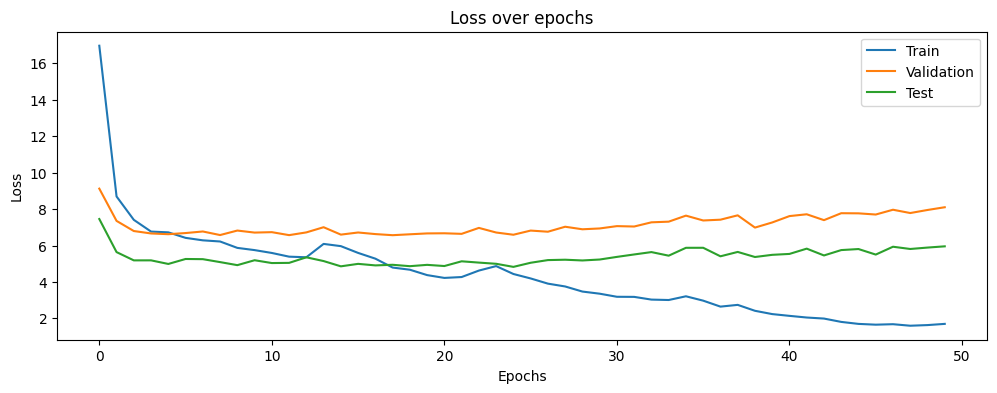

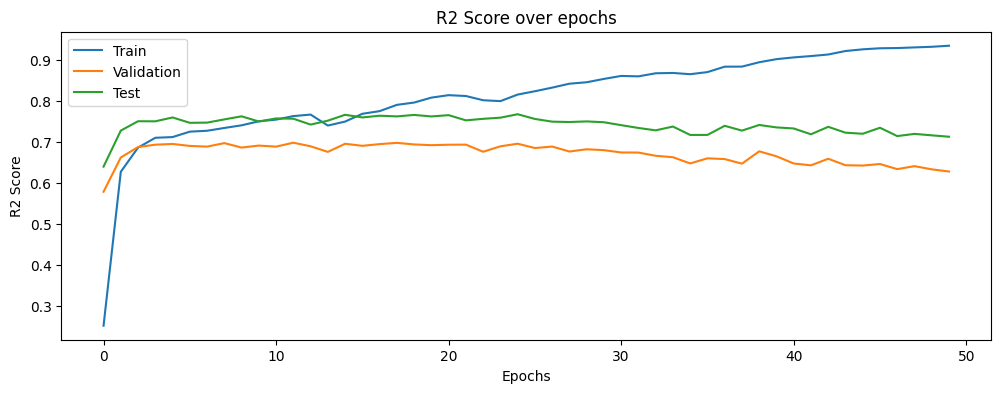

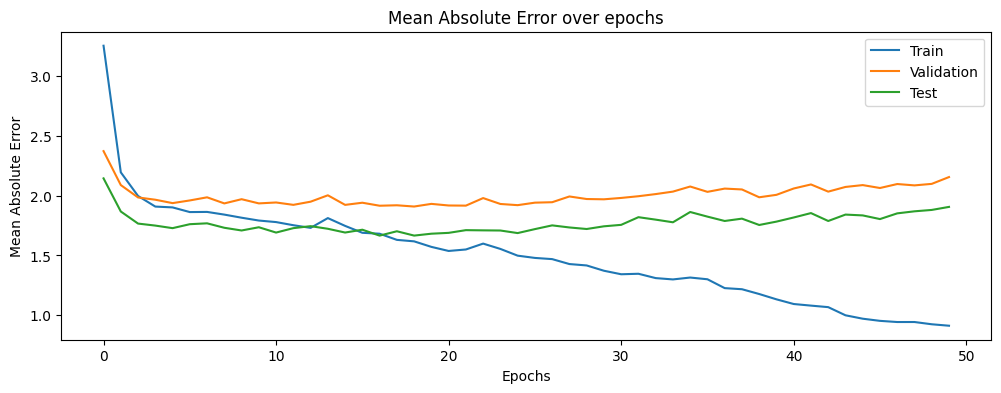

In [25]:
# Plot losses
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot R2 scores
plt.figure(figsize=(12, 4))
plt.plot(train_r2_scores, label='Train')
plt.plot(val_r2_scores, label='Validation')
plt.plot(test_r2_scores, label='Test')
plt.title('R2 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

# Plot MAEs
plt.figure(figsize=(12, 4))
plt.plot(train_maes, label='Train')
plt.plot(val_maes, label='Validation')
plt.plot(test_maes, label='Test')
plt.title('Mean Absolute Error over epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [26]:
def test_example(idx):
    example = data_list_test[idx]
    print(f'Number of objects = {example.x.shape[0]}')
    pred = model(example)
    true = example.y
    print(f'Predicted = \n {pred},\n Ground-truth = \n {true}')

test_example(5)

Number of objects = 7
Predicted = 
 tensor([[-0.1758, -4.3902],
        [ 1.4705,  2.8137],
        [ 1.2447, -3.8989],
        [-6.3218, -0.6364],
        [ 6.5689, -0.7150],
        [ 6.9842,  0.7016],
        [-4.1160, -0.9244]], grad_fn=<AddBackward0>),
 Ground-truth = 
 tensor([[ 2.9941, -5.2138],
        [ 1.8626,  7.2901],
        [-0.8698, -4.8716],
        [-3.7912, -1.6376],
        [ 8.4632,  1.6116],
        [ 6.4506, -1.2052],
        [-5.1832, -0.3881]])


# Task 2